# Kaggle Project

## Describe Your Dataset

**URL:** https://www.kaggle.com/datasets/manishshah120/facial-expression-recog-image-ver-of-fercdataset

**Task:**

1. 데이터셋의 구성과 활용
2. 데이터로더 정의 
   - pc 사양에 맞는 batch_size 설정
   - torchvision transform을 이용한 data augmentation 적용
3. 이미지 출력상태 확인
4. 딥러닝 모델 구성
5. 학습 진행
6. 평가 결과 확인

**Datasets**

사람 얼굴의 표정을 7개의 class로 나누어 구분


**Features(x):**

'anger', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise'


**Target(y):**

Classification


---

# Code

##### Github : https://github.com/ManikantaSanjay/Emotion_Prediction_Kaggle_CNN

### Library

In [1]:
import numpy as np
import pandas as pd
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
from PIL import Image
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
import torchvision.models as models
from torch.utils.data import DataLoader
import torchvision.transforms as transform
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

### Check image directory 

In [2]:
data_dir = 'C:/Users/ATRC/Desktop/archive/Dataset'
print(os.listdir(data_dir))

['labels.txt', 'test', 'train']


In [3]:
# 클래스 정보확인
classes = os.listdir(data_dir + '/train')
print(classes)

['anger', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise']


### Datasets

In [4]:
# 기본 Raw data를 이용한 Transform

train_transform = transform.Compose([transform.ToTensor()])
valid_transform = transform.Compose([transform.ToTensor()])


# Train Augmentation을 위한 Transform

train_transform_2 = transform.Compose([
                        transform.RandomHorizontalFlip(),
                        transform.RandomRotation(30),
                        transform.ColorJitter(brightness=0.1, contrast=0.25, saturation=0.35, hue=0.05),
                        transform.RandomRotation(10, resample=False, expand=False, center=None, fill=None),
                        transform.ToTensor()])

c:\users\atrc\anaconda3\envs\test\lib\site-packages\torchvision\transforms\transforms.py:1248: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  warnings.warn(


In [5]:
# Dataset 구성

train_set = ImageFolder(data_dir+'/train', train_transform)
valid_set = ImageFolder(data_dir+'/test', valid_transform)

# Aumentation train_set

train_set_2 = ImageFolder(data_dir+'/train', train_transform_2)

In [6]:
# Batch_size 설정

batch_size = 8

In [7]:
# Dataloader 구성

train_loader = DataLoader(train_set, batch_size, num_workers=0, pin_memory=True)
valid_loader = DataLoader(valid_set, batch_size, num_workers=0, pin_memory=True)


train_loader_2 = DataLoader(train_set_2, batch_size, num_workers=0, pin_memory=True)

### Show images

In [8]:
# Batch_size에 따른 이미지 확인 함수 설정

def show_batch(x):
    for images, labels in x:
        fig, axis = plt.subplots(figsize=(12,12))
        axis.set_xticks([])
        axis.set_yticks([])
        axis.imshow(make_grid(images[:64], nrow=16).permute(1, 2, 0))
        break

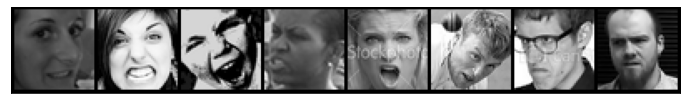

In [9]:
show_batch(train_loader)

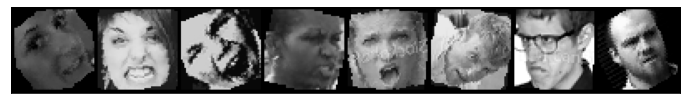

In [10]:
show_batch(train_loader_2)

In [11]:
# 이미지 Shape 확인

train_iter = iter(train_loader)
images, labels = train_iter.next()
images.shape

torch.Size([8, 3, 48, 48])

### CUDA device setting

In [12]:
def get_default_device(): # 디바이스 사용 가능상태 확인후 선택
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):  # 선택한 디바이트에 따른 Tensor
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [13]:
# Device 상태 확인
device = get_default_device()
device

device(type='cuda')

In [14]:
# Device로 Dataloader 변경

train_dl = DeviceDataLoader(train_loader, device)
valid_dl = DeviceDataLoader(valid_loader, device)

train_dl_2 = DeviceDataLoader(train_loader_2, device)

### Train, Validation setting

In [15]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  
        loss = F.cross_entropy(out, labels) # 크로스엔트로피 loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                 
        loss = F.cross_entropy(out, labels)   
        acc = accuracy(out, labels)           
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

### Model - ResNet9

In [16]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [37]:
class CNN(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
#         self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
#         self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
#         out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
#         out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [17]:
model = to_device(ResNet9(3, 7), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [38]:
model_2 = to_device(CNN(3, 7), device)
model_2

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, tr

### Train

In [18]:
from tqdm.notebook import tqdm

In [19]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
#     history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [20]:
def fit_one_cycle_2(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
#     history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history_2.append(result)
    return history_2

In [21]:
# fit_one_cycle에 필요한 변수 설정

epochs = 10
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [33]:
%%time
history = []
history += fit_one_cycle(
                epochs, 
                max_lr, 
                model, 
                train_dl, 
                valid_dl, 
                grad_clip=grad_clip, 
                weight_decay=weight_decay, 
                opt_func=opt_func
                )

  0%|          | 0/4038 [00:00<?, ?it/s]

Epoch [0], last_lr: 0.00280, train_loss: 0.0822, val_loss: 13.9822, val_acc: 0.1166


  0%|          | 0/4038 [00:00<?, ?it/s]

Epoch [1], last_lr: 0.00760, train_loss: 0.0784, val_loss: 17.5036, val_acc: 0.1166


  0%|          | 0/4038 [00:00<?, ?it/s]

Epoch [2], last_lr: 0.01000, train_loss: 0.0674, val_loss: 36.9444, val_acc: 0.1166


  0%|          | 0/4038 [00:00<?, ?it/s]

Epoch [3], last_lr: 0.00950, train_loss: 0.0699, val_loss: 18.7408, val_acc: 0.1166


  0%|          | 0/4038 [00:00<?, ?it/s]

Epoch [4], last_lr: 0.00812, train_loss: 0.0611, val_loss: 18.9403, val_acc: 0.1166


  0%|          | 0/4038 [00:00<?, ?it/s]

Epoch [5], last_lr: 0.00611, train_loss: 0.0731, val_loss: 15.3893, val_acc: 0.1166


  0%|          | 0/4038 [00:00<?, ?it/s]

Epoch [6], last_lr: 0.00389, train_loss: 0.0786, val_loss: 23.7370, val_acc: 0.1166


  0%|          | 0/4038 [00:00<?, ?it/s]

Epoch [7], last_lr: 0.00188, train_loss: 0.1245, val_loss: 13.2737, val_acc: 0.1166


  0%|          | 0/4038 [00:00<?, ?it/s]

Epoch [8], last_lr: 0.00050, train_loss: 0.1164, val_loss: 11.3470, val_acc: 0.1166


  0%|          | 0/4038 [00:00<?, ?it/s]

Epoch [9], last_lr: 0.00000, train_loss: 0.5631, val_loss: 2.6349, val_acc: 0.1654
Wall time: 8min 1s


### Train2 - train_set with Augmentation

In [24]:
%%time
history_2 = []
history_2 += fit_one_cycle_2(
                    epochs, 
                    max_lr, 
                    model, 
                    train_dl_2, 
                    valid_dl, 
                    grad_clip=grad_clip, 
                    weight_decay=weight_decay, 
                    opt_func=opt_func
                    )

  0%|          | 0/4038 [00:00<?, ?it/s]

Epoch [0], last_lr: 0.00280, train_loss: 0.0712, val_loss: 13.2985, val_acc: 0.1166


  0%|          | 0/4038 [00:00<?, ?it/s]

Epoch [1], last_lr: 0.00760, train_loss: 0.0764, val_loss: 19.7024, val_acc: 0.1166


  0%|          | 0/4038 [00:00<?, ?it/s]

Epoch [2], last_lr: 0.01000, train_loss: 0.0626, val_loss: 18.5475, val_acc: 0.1166


  0%|          | 0/4038 [00:00<?, ?it/s]

Epoch [3], last_lr: 0.00950, train_loss: 0.0566, val_loss: 17.3065, val_acc: 0.1166


  0%|          | 0/4038 [00:00<?, ?it/s]

Epoch [4], last_lr: 0.00812, train_loss: 0.0652, val_loss: 15.9230, val_acc: 0.1166


  0%|          | 0/4038 [00:00<?, ?it/s]

Epoch [5], last_lr: 0.00611, train_loss: 0.0650, val_loss: 16.5178, val_acc: 0.1166


  0%|          | 0/4038 [00:00<?, ?it/s]

Epoch [6], last_lr: 0.00389, train_loss: 0.0875, val_loss: 17.6861, val_acc: 0.1166


  0%|          | 0/4038 [00:00<?, ?it/s]

Epoch [7], last_lr: 0.00188, train_loss: 0.1194, val_loss: 14.0687, val_acc: 0.1166


  0%|          | 0/4038 [00:00<?, ?it/s]

Epoch [8], last_lr: 0.00050, train_loss: 0.1568, val_loss: 9.1149, val_acc: 0.1166


  0%|          | 0/4038 [00:00<?, ?it/s]

Epoch [9], last_lr: 0.00000, train_loss: 0.7451, val_loss: 2.3682, val_acc: 0.1654
Wall time: 10min 56s


### Performance & Evaluation graph

In [25]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.')

In [26]:
def plot_accuracies_2(history_2):
    accuracies = [x['val_acc'] for x in history_2]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    
def plot_losses_2(history_2):
    train_losses = [x.get('train_loss') for x in history_2]
    val_losses = [x['val_loss'] for x in history_2]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    
def plot_lrs_2(history_2):
    lrs = np.concatenate([x.get('lrs', []) for x in history_2])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.')

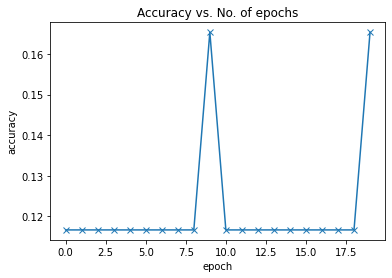

In [34]:
plot_accuracies(history)

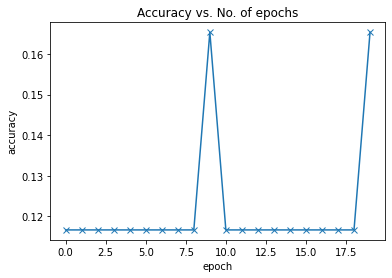

In [28]:
plot_accuracies_2(history_2)

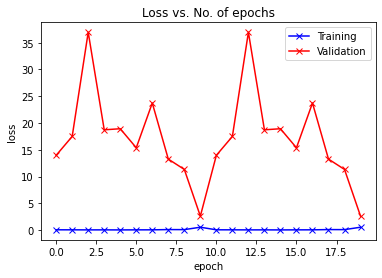

In [35]:
plot_losses(history)

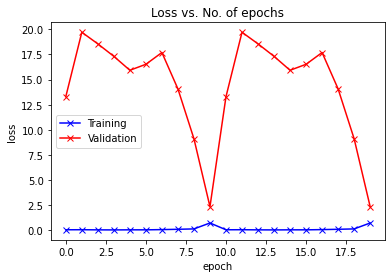

In [30]:
plot_losses_2(history_2)

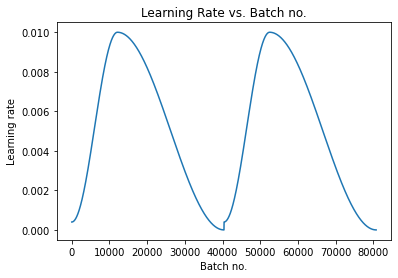

In [36]:
plot_lrs(history)

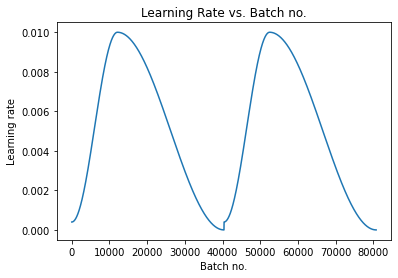

In [32]:
plot_lrs_2(history_2)

### Model change

In [39]:
%%time
history = []
history += fit_one_cycle(
                epochs, 
                max_lr, 
                model_2, 
                train_dl, 
                valid_dl, 
                grad_clip=grad_clip, 
                weight_decay=weight_decay, 
                opt_func=opt_func
                )

  0%|          | 0/4038 [00:00<?, ?it/s]

Epoch [0], last_lr: 0.00280, train_loss: 0.2113, val_loss: 18.2929, val_acc: 0.1166


  0%|          | 0/4038 [00:00<?, ?it/s]

Epoch [1], last_lr: 0.00760, train_loss: 0.3036, val_loss: 11.7357, val_acc: 0.1166


  0%|          | 0/4038 [00:00<?, ?it/s]

Epoch [2], last_lr: 0.01000, train_loss: 0.1664, val_loss: 13.8854, val_acc: 0.1166


  0%|          | 0/4038 [00:00<?, ?it/s]

Epoch [3], last_lr: 0.00950, train_loss: 0.1317, val_loss: 10.3299, val_acc: 0.1166


  0%|          | 0/4038 [00:00<?, ?it/s]

Epoch [4], last_lr: 0.00812, train_loss: 0.0713, val_loss: 10.9498, val_acc: 0.1166


  0%|          | 0/4038 [00:00<?, ?it/s]

Epoch [5], last_lr: 0.00611, train_loss: 0.0846, val_loss: 18.5134, val_acc: 0.1166


  0%|          | 0/4038 [00:00<?, ?it/s]

Epoch [6], last_lr: 0.00389, train_loss: 0.0904, val_loss: 16.6383, val_acc: 0.1166


  0%|          | 0/4038 [00:00<?, ?it/s]

Epoch [7], last_lr: 0.00188, train_loss: 0.1552, val_loss: 11.5156, val_acc: 0.1166


  0%|          | 0/4038 [00:00<?, ?it/s]

Epoch [8], last_lr: 0.00050, train_loss: 0.1832, val_loss: 11.0740, val_acc: 0.1166


  0%|          | 0/4038 [00:00<?, ?it/s]

Epoch [9], last_lr: 0.00000, train_loss: 1.3684, val_loss: 1.8917, val_acc: 0.2447
Wall time: 5min 32s


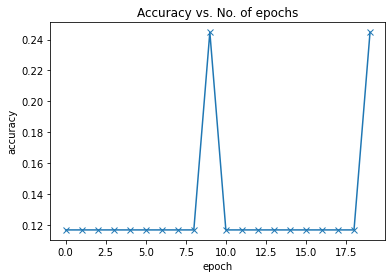

In [40]:
plot_accuracies(history)

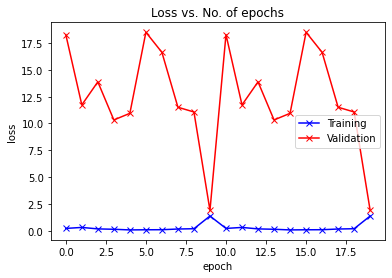

In [41]:
plot_losses(history)

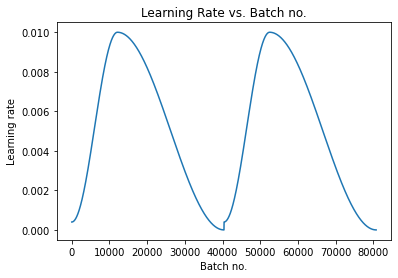

In [42]:
plot_lrs(history)

### ResNet 과 일반 CNN 모델 성능 비교

In [43]:
correct = 0
total = 0
for images, labels in valid_dl:
    
    outputs = model(images)
    
    _, predicted = torch.max(outputs.data, 1)
    
    total += labels.size(0)
    correct += (predicted == labels).sum()
    
print('Accuracy of test images: %f %%' % (100* float(correct)/ total))

Accuracy of test images: 16.550571 %


In [44]:
correct = 0
total = 0
for images, labels in valid_dl:
    
    outputs = model_2(images)
    
    _, predicted = torch.max(outputs.data, 1)
    
    total += labels.size(0)
    correct += (predicted == labels).sum()
    
print('Accuracy of test images: %f %%' % (100* float(correct)/ total))

Accuracy of test images: 24.491502 %


---

The results explains

데이터 Augmentation을 이용한 성능 비교 --> 큰 차이 없음  
모델 변경을 이용한 성능 비교 --> CNN 성능이 더 좋음